In [18]:
import numpy as np
import pandas as pd
from sklearn import svm
import random
import os
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle



In [ ]:
def training_function(SE,SE_drugs,all_drugs,features_dir,n_outer,MPP_dict,random_state=42):
    np.random.seed(random_state)
    #auc_SE=np.zeros((len(SE_drugs),n_outer))
    drugs_SE=None
    auc_drug_dict_mean={}
    auc_drug_dict_std={}
    auc_all_runs=[]
    fpr_list=[]
    tpr_list=[]
    for i in range(n_outer):
        print(i)
        n_pos=len(SE_drugs)
        n_neg=n_pos
        pos_SE_drugs = set(SE_drugs)
        eligible = [item for item in all_drugs if item not in pos_SE_drugs]
        pos_samples=SE_drugs
        scores_for_SE_score=[]
        scores_for_SE_true=[]
        #print(eligible)
        #print(n_neg)
        try:
            neg_samples=random.sample(eligible,n_neg)#sampling negative samples to train on
        except:
            pos_samples=random.sample(SE_drugs,len(eligible))
            neg_samples=random.sample(eligible,len(eligible))
            n_pos=len(pos_samples)
            n_neg=len(neg_samples)
        for j in range(0,len(pos_samples)):
            #j'th drug will be left out
            #constructing test/leave out sets
            drug_pos_test=pos_samples[j]
            drug_neg_test=neg_samples[j]#randomly selecting leave out for negative
            drug_pos_test_df=pd.read_csv(f'{features_dir}fva_bounds_{drug_pos_test}.csv',header=None)
            drug_pos_test_pd=pd.concat([drug_pos_test_df[0],drug_pos_test_df[1]],axis=0,ignore_index=True)
            drug_neg_test_df=pd.read_csv(f'{features_dir}fva_bounds_{drug_neg_test}.csv',header=None)
            drug_neg_test_pd=pd.concat([drug_neg_test_df[0],drug_neg_test_df[1]],axis=0,ignore_index=True)
            X_test=np.array([drug_pos_test_pd,drug_neg_test_pd])
            Y_test=np.array([1,0])
            #constructing the training set
            X_train=np.zeros((2*(n_pos),4732))
            Y_train=np.zeros((2*(n_pos),1))
            for k_pos in range(0,n_pos):
                
                drug_pos_train_df=pd.read_csv(f'{features_dir}fva_bounds_{pos_samples[k_pos]}.csv',header=None)
                drug_pos_train_pd=pd.concat([drug_pos_train_df[0],drug_pos_train_df[1]],axis=0,ignore_index=True)
                #print(f'changing {k_pos} elements')
                X_train[k_pos]=drug_pos_train_pd
                Y_train[k_pos]=1

            for k_neg in range(0,n_pos):
                
                drug_neg_train_df=pd.read_csv(f'{features_dir}fva_bounds_{neg_samples[k_neg]}.csv',header=None)
                drug_neg_train_pd=pd.concat([drug_neg_train_df[0],drug_neg_train_df[1]],axis=0,ignore_index=True)
                X_train[n_pos + k_neg]=drug_neg_train_pd
                #print(f'changed {(n_pos-1) + k_neg} element')
                Y_train[n_pos + k_neg]=0
            #training set has been constructed
            X_train_master=X_train
            Y_train_master=Y_train
            X_train=np.delete(X_train,n_pos+j,0)
            Y_train=np.delete(Y_train,n_pos+j,0)
            X_train=np.delete(X_train,j,0)
            Y_train=np.delete(Y_train,j,0)
            #print(f'leaving out {SE_drugs[j]}')
            Y_train=list(Y_train)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            #clf = GaussianNB()
            #clf = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500)
            #clf = KNeighborsClassifier(n_neighbors=10)
            clf = svm.SVC(kernel='linear',probability=True,random_state=random_state,C=10)
            #clf = RandomForestClassifier(n_estimators=1000, random_state=42)
            clf.fit(X_train_scaled,np.ravel(Y_train))
            
            probas = clf.predict_proba(X_test_scaled)[:,1]
            for u in range(0,len(Y_test)):
                scores_for_SE_score.append(probas[u])
                scores_for_SE_true.append(Y_test[u])

            
            
            #fpr, tpr, thresholds = roc_curve(Y_test, probas)
            #print(fpr,tpr,thresholds)
            #roc_auc = auc(fpr, tpr)
            #auc_SE[j][i]=roc_auc
            #drugs_SE.append(SE_drugs[j])
        fpr,tpr,thresholds=roc_curve(scores_for_SE_true,scores_for_SE_score)
        #print(fpr,tpr)
        roc_auc=auc(fpr,tpr)
        fpr_list.append(fpr)
        tpr_list.append(tpr)
        auc_all_runs.append(roc_auc)
    #training and saving MPP to a dict file
    clf = svm.SVC(kernel='linear',probability=True,random_state=random_state)
    clf.fit(X_train_master,np.ravel(Y_train_master))
    MPP_dict[SE]=clf
    print(f'Trained MPP for {SE}')
    
    
    return fpr_list[auc_all_runs.index(max(auc_all_runs))],tpr_list[auc_all_runs.index(max(auc_all_runs))],max(auc_all_runs),np.mean(auc_all_runs),np.std(auc_all_runs),fpr,tpr

# Extract keys and values
    keys = list(auc_drug_dict_mean.keys())
    values = list(auc_drug_dict_mean.values())
    std_values=list(auc_drug_dict_std.values())

# Create a bar plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=keys, y=values, s=100, color='b', label="AUC")
    plt.errorbar(keys, values, yerr=std_values, fmt='o', color='b', capsize=5)

    plt.bar(keys, values, color='skyblue', edgecolor='black')

# Add labels and title
    plt.xlabel("Drugs")
    plt.ylabel("AUC Score")
    plt.title("AUC scores for different SE predictors")

# Show the plot
    plt.show()
    plt.savefig(f"C:/Users/Saathvik/Documents/MATLAB/Project_Recon3D/data/AUC_plots/auc_{SE}_{n_outer}.png", dpi=300, bbox_inches='tight')
    
        











starting training C0000731
0
1
2
3
4
5
6
7
8
9
Trained MPP for C0000731
0.5107638888888888
0.7222222222222221
0.1411230890859045


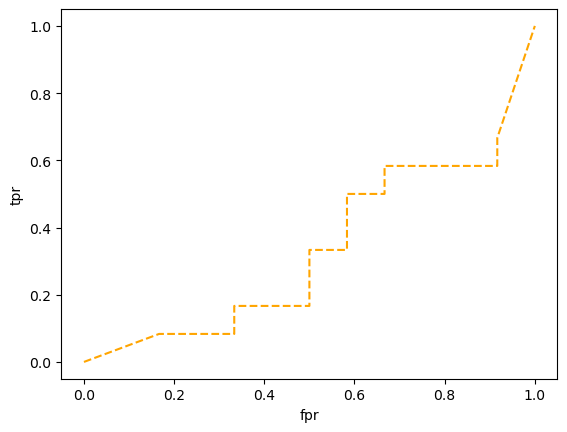

[0.         0.16666667 0.16666667 0.33333333 0.33333333 0.58333333
 0.58333333 0.66666667 1.        ] [0.         0.33333333 0.66666667 0.66666667 0.75       0.75
 0.91666667 0.91666667 1.        ]
{'C0000731': SVC(kernel='linear', probability=True, random_state=42)}


In [ ]:
fva_bounds_norm_dir='C:/Users/Saathvik/Documents/MATLAB/Project_Liver/data/FVA_Bounds_norm3/'
df_all_drugs=pd.read_csv("C:/Users/Saathvik/Documents/MATLAB/Project_Liver/data/DrugBank/drug_gene_targets_meta_1.csv")
all_drugs=df_all_drugs['dg_id']
#print(len(all_drugs))
df_SE=pd.read_csv("C:/Users/Saathvik/Documents/MATLAB/Project_Liver/data/SIDER/side_effects_vs_causative_drugs_meta.csv")
#AMPP Training only
MPP_dict={}
fpr_dict={}
tpr_dict={}

n_outer=10
for k in range(0,1):
    for se in range(0,len(df_SE['concept_id'])):
        
        '''if se>10:
            continue'''
        if (df_SE['concept_id'][se]!='C0000731'):
            continue
        SE_drugs=df_SE['dg_id'][se].split(',')
        for i in range(0,len(SE_drugs)):
            SE_drugs[i]=SE_drugs[i].lstrip()
        print(f'starting training {df_SE['concept_id'][se]}')
        
        fpr_m,tpr_m,m,auc_mean,auc_std,fpr,tpr=training_function(df_SE['concept_id'][se],SE_drugs,all_drugs,fva_bounds_norm_dir,n_outer,MPP_dict)
        fpr_dict[df_SE['concept_id'][se]]=fpr_m
        tpr_dict[df_SE['concept_id'][se]]=tpr_m 
    print(auc_mean)
    print(m)
    print(auc_std)
    plt.plot(fpr, tpr, linestyle='--',color='orange')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.show()
    print(fpr_m,tpr_m)
#writing trained AMPP dict to pkl file AMPP.pkl
print(MPP_dict)

with open('C:/Users/Saathvik/Documents/MATLAB/Project_Liver/data/AMPP/AMPP_temp.pkl', 'wb') as file:
    pickle.dump(MPP_dict, file)
with open('C:/Users/Saathvik/Documents/MATLAB/Project_Liver/data/AMPP/fpr-tpr_temp.pkl', 'wb') as file:
    pickle.dump([fpr_dict,tpr_dict], file)



    
        


# AMPP Workflow

In [ ]:
with open('C:/Users/Saathvik/Documents/MATLAB/Project_Liver/data/AMPP/fpr-tpr_temp.pkl', 'rb') as file:
    loaded_dict = pickle.load(file)
fpr,tpr=loaded_dict[0],loaded_dict[1]
#se_test='C0000731,C0000737,C0002622,C0002792,C0002170,C0001925,C0001824,C0000833,C0002871,C0002874,C0002878'
#se_test=se_test.split(',')
aucs={}
for i in fpr.keys():
    roc_auc=auc(fpr[i],tpr[i])
    aucs[i]=roc_auc
for drug, score in sorted(aucs.items(), key=lambda item: item[1], reverse=True):
    print(f"{drug}: {score}")


C0032617: 0.7847222222222222
C0302295: 0.78
C0023380: 0.768888888888889
C0031117: 0.768888888888889
C0018834: 0.7681660899653979
C0232461: 0.7602040816326531
C0267792: 0.76
C0030920: 0.75390625
C0034063: 0.7525510204081632
C0005778: 0.75
C0008325: 0.75
C0003864: 0.7444444444444445
C0019360: 0.7396694214876033
C0027697: 0.7368421052631579
C0004936: 0.7355555555555555
C0013295: 0.7355371900826446
C0702166: 0.731404958677686
C0042075: 0.7272727272727273
C0149931: 0.7270408163265307
C0017160: 0.7221074380165289
C0085584: 0.72
C0037763: 0.71900826446281
C0086543: 0.7177777777777778
C0037274: 0.7152777777777778
C0042798: 0.7152777777777778
C0851578: 0.7148760330578512
C0030252: 0.7100591715976331
C0041912: 0.7071330589849107
C0332575: 0.7050000000000001
C0021167: 0.7044444444444444
C0004238: 0.7022222222222223
C0027651: 0.701171875
C0018418: 0.698961937716263
C0036572: 0.6975308641975307
C0006266: 0.69140625
C0423791: 0.6863905325443787
C0014868: 0.685595567867036
C0031256: 0.684027777777777

In [ ]:
#sanity test
with open('C:/Users/Saathvik/Documents/MATLAB/Project_Liver/data/AMPP/AMPP.pkl', 'rb') as file:
    loaded_classifiers = pickle.load(file)
clf=loaded_classifiers['C0000731']
probas = clf.predict_proba(X_test)[:,1]


In [ ]:
        keys = list(auc_drug_dict_mean.keys())
        values = list(auc_drug_dict_mean.values())
        std_values=auc_drug_dict_std.values()

# Create a bar plot
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=keys, y=values, s=50, color='b', label="AUC")
        plt.errorbar(keys, values, yerr=list(std_values/10), fmt='o', color='b', capsize=3)

        plt.bar(keys, values, color='skyblue', edgecolor='black')

# Add labels and title
        plt.xlabel("Drugs")
        plt.ylabel("AUC Score")
        plt.title("AUC scores for different SE predictors")

# Show the plot
        plt.show()
        plt.savefig(f"C:/Users/Saathvik/Documents/MATLAB/Project_Recon3D/data/AUC_plots/auc_{df_SE['concept_id'][se]}_{n_outer}_{k}.png", dpi=300, bbox_inches='tight')
    
    

NameError: name 'auc_drug_dict_mean' is not defined